In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from keras import backend as K
from keras.models import Model
from keras import optimizers
import numpy as np
import os, pickle, sys, time
from BBalpha_dropout import *
from collections import defaultdict
from timeit import default_timer as timer

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# gaussian parameters
dim = 2
mu1 = -5
mu2 = -mu1
s1 = 1
s2 = s1

# dataset parameters
ntrain = 5000
nval = 1000

# MC sample parameters
K_mc = 10
K_test = 100

# network parameters
nb_layers = 2
nb_units = 100
p = 0.5
wd = 1e-6
nb_classes = 2
dropout = 'MC'
alpha = 0.5
epochs = 10

In [3]:
xtrain = np.concatenate((np.random.normal(mu1, s1, (int(ntrain/2), dim)),
                         np.random.normal(mu2, s2, (int(ntrain/2), dim))),
                         axis=0)
ytrain = np.concatenate((np.zeros((int(ntrain/2), )),
                         np.ones((int(ntrain/2), ))),
                        axis=0)
xval = np.concatenate((np.random.normal(mu1, s1, (int(nval/2), dim)),
                       np.random.normal(mu2, s2, (int(nval/2), dim))),
                       axis=0)
yval = np.concatenate((np.zeros((int(nval/2), )),
                       np.ones((int(nval/2), ))),
                       axis=0)
# xtest is a grid
testvals = np.linspace(mu1 - 5 * s1, mu2 + 5 * s2, 100)
args = dim * [testvals]
xtest = np.reshape(np.stack(np.meshgrid(*args), axis=-1), (-1, dim))
ytest = np.zeros((len(xtest),)) # just say it's all zero for plotting purposes

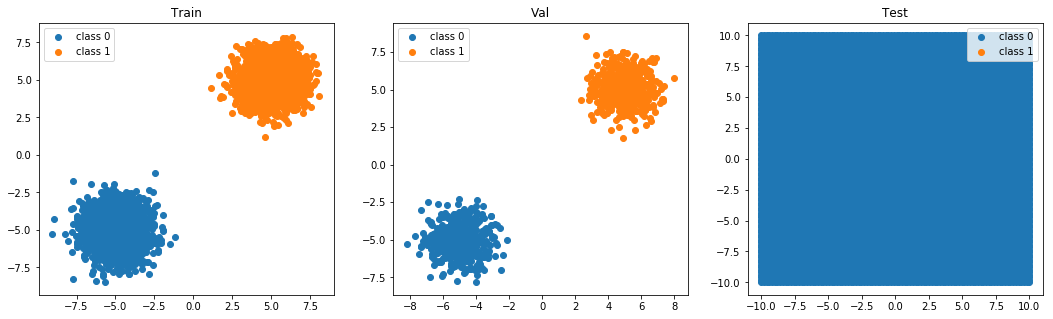

In [4]:
# plot the distributions
assert dim == 1 or dim == 2, 'Use dim = 1 or dim = 2 to plot'
f, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['Train', 'Val', 'Test']
xdata = [xtrain, xval, xtest]
ydata = [ytrain, yval, ytest]
for (ax, title, x, y) in zip(axes, titles, xdata, ydata):
    xpos = x[np.where(y == 0)]
    xneg = x[np.where(y == 1)]
    if dim == 1:
        ax.hist(xpos, label="class 0")
        ax.hist(xneg, label="class 1")
    if dim == 2:
        ax.scatter(xpos[:,0], xpos[:,1], label="class 0")
        ax.scatter(xneg[:,0], xneg[:,1], label="class 1")
    ax.set_title(title)
    ax.legend()

In [5]:
# build the model
input_shape = (dim, )
ytraincat = np_utils.to_categorical(ytrain, nb_classes)
yvalcat = np_utils.to_categorical(yval, nb_classes)
ytestcat = np_utils.to_categorical(ytest, nb_classes)
inp = Input(shape=input_shape)
# layers = get_logit_mlp_layers(nb_layers, nb_units, p, wd, nb_classes, layers = [], \
#                               dropout=dropout)
D = Dropout_mc
layers = []
for ii in range(nb_layers):
    if True: # ii != 0:
        layers.append(D(p))
    layers.append(Dense(nb_units, activation='relu', kernel_regularizer=l2(wd)))
layers.append(D(p))
layers.append(Dense(nb_classes, kernel_regularizer=l2(wd))) # these are logit activations!

mc_logits = GenerateMCSamples(inp, layers, K_mc) # repeats stochastic layers K_mc times
# if alpha = 0.0, bbalpha returns categorical cross entropy with logits
loss_function = bbalpha_softmax_cross_entropy_with_mc_logits(alpha)
model = Model(inputs=inp, outputs=mc_logits)
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss=loss_function, 
              metrics=['accuracy', loss_function, metric_avg_acc, metric_avg_ll])

In [6]:
ytraindup = np.squeeze(np.concatenate(K_mc * [ytraincat[:, None]], axis=1)) # N x K_mc x D
yvaldup= np.squeeze(np.concatenate(K_mc * [yvalcat[:, None]], axis=1)) # N x K_mc x D

In [7]:
# training loop

results = defaultdict(list)
max_acc = 0.
max_acc_ep = 0
ep = 0
while ep < max(2 * max_acc_ep, epochs):
# while ep < epochs:
    tic = timer()
    history = model.fit(xtrain, ytraindup, verbose=1,
                        initial_epoch=ep, epochs=ep+1,
                        validation_data=(xval, yvaldup))
    toc = timer()
    results['train_N'].append(xtrain.shape[0]) 
    results['val_N'].append(xval.shape[0]) 
    results['time'].append(toc-tic)
    results['train_total_loss'].extend(history.history['loss'])
    results['train_bbalpha_loss'].extend(history.history['bbalpha_loss'])
    results['train_acc'].extend(history.history['acc'])
    results['train_avg_acc'].extend(history.history['metric_avg_acc'])
    results['train_ll'].extend(history.history['metric_avg_ll'])
    results['val_total_loss'].extend(history.history['val_loss'])
    results['val_bbalpha_loss'].extend(history.history['val_bbalpha_loss'])
    results['val_acc'].extend(history.history['val_acc'])
    results['val_avg_acc'].extend(history.history['val_metric_avg_acc'])
    results['val_ll'].extend(history.history['val_metric_avg_ll'])
    
    val_avg_acc = results['val_avg_acc'][-1]
    if val_avg_acc > max_acc:
        max_acc = val_avg_acc
        max_acc_ep = ep
        model.save('two-gaussian-model.h5')
        print("Updating max_acc_ep: {}".format(max_acc_ep))
    print("max_acc_ep: {}\t max_acc: {:.3f}".format(max_acc_ep, max_acc))
    ep += 1

Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 1s 278us/step - loss: 0.1718 - acc: 0.8655 - bbalpha_loss: 0.1717 - metric_avg_acc: 0.9956 - metric_avg_ll: -0.1523 - val_loss: 0.1595 - val_acc: 0.8710 - val_bbalpha_loss: 0.1594 - val_metric_avg_acc: 1.0000 - val_metric_avg_ll: -0.1417
Updating max_acc_ep: 0
max_acc_ep: 0	 max_acc: 1.000
Train on 5000 samples, validate on 1000 samples
Epoch 2/2
5000/5000 [==============================] - 1s 154us/step - loss: 0.1565 - acc: 0.8737 - bbalpha_loss: 0.1564 - metric_avg_acc: 1.0000 - metric_avg_ll: -0.1389 - val_loss: 0.1544 - val_acc: 0.8763 - val_bbalpha_loss: 0.1543 - val_metric_avg_acc: 1.0000 - val_metric_avg_ll: -0.1370
max_acc_ep: 0	 max_acc: 1.000
Train on 5000 samples, validate on 1000 samples
Epoch 3/3
5000/5000 [==============================] - 1s 161us/step - loss: 0.1566 - acc: 0.8756 - bbalpha_loss: 0.1565 - metric_avg_acc: 1.0000 - metric_avg_ll: -0.1390 - val_loss: 0.15

In [8]:
from keras.models import load_model
from numpy import ma
file_name = 'two-gaussian-model.h5'
model = load_model(file_name, custom_objects={'bbalpha_loss': bbalpha_softmax_cross_entropy_with_mc_logits(alpha),
                                              'metric_avg_acc': metric_avg_acc,
                                              'metric_avg_ll': metric_avg_ll})
mc_logits = GenerateMCSamples(inp, model.layers[1:-1], K_test) # repeats stochastic layers nb_test
mc_softmax = Activation('softmax')(mc_logits)  # softmax is over last dim
test_model = Model(inputs=inp, outputs=mc_softmax) # check the dimensions of this model

In [9]:
pred = test_model.predict(xtest)
avg_pc = np.mean(pred, axis=1)
predictive = - np.sum(avg_pc * ma.log2(avg_pc).filled(0), axis=-1)
aleatoric = - 1/K_test * np.sum(pred * ma.log2(pred).filled(0), axis=(1,2))
epistemic = predictive - aleatoric

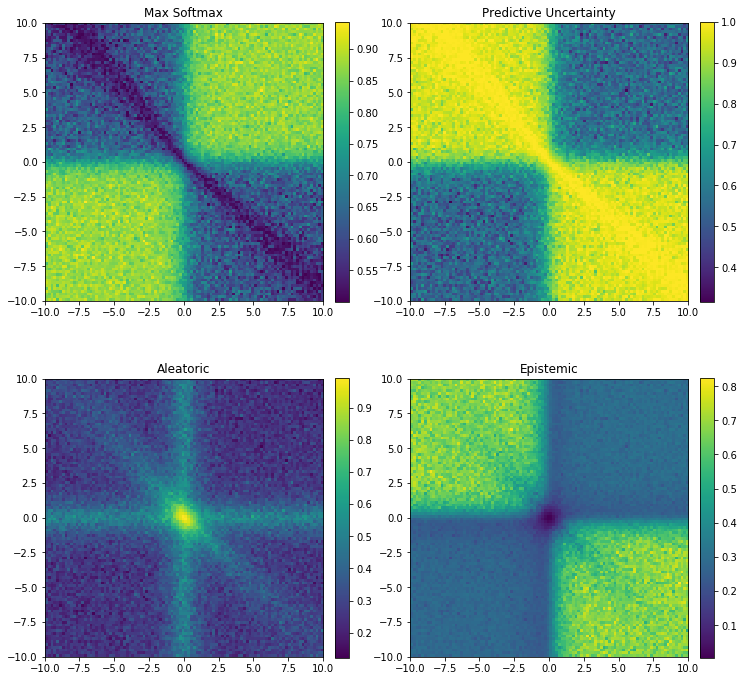

In [10]:
data = [np.max(avg_pc, axis=1), predictive, aleatoric, epistemic]
labels = ['Max Softmax', 'Predictive Uncertainty', 'Aleatoric', 'Epistemic']
if dim == 1:
    f, axes = plt.subplots(4, 1, figsize=(12, 12))
    for (ax, value, title) in zip(axes, data, labels):
        ax.plot(xtest, value)
        ax.set_title(title)
    f.tight_layout()
if dim == 2:
    f, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = [item for sublist in axes for item in sublist]
    for (ax, value, title) in zip(axes, data, labels):
        im = ax.imshow(np.reshape(value, (len(testvals), len(testvals))), origin='lower', 
                       extent=[min(testvals), max(testvals),min(testvals), max(testvals)])
        ax.set_title(title)
        f.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

In [11]:
def max_softmax_uncertainty(softmax, predictive, epistemic, aleatoric):
    max_softmax = np.max(softmax, axis=1)
    uncertainties = [predictive, epistemic, aleatoric]
    titles = ['Predictive', 'Epistemic', 'Aleatoric']
    f, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ii, (uncertainty, title) in enumerate(zip(uncertainties, titles)):
        ax1 = axes[ii]
        ax1.scatter(uncertainty, max_softmax)
        ax1.set_title(title + ' Uncertainty: Correct Points')
        ax1.set_ylabel('Softmax')
        ax1.set_xlabel('Uncertainty')
        [r, p] = scipy.stats.pearsonr(uncertainty, max_softmax)
        print("Correlation: {}, r={:.3f}, p={}".format(title, r, p))
    f.tight_layout()
    # f.savefig(path)

Correlation: Predictive, r=-0.977, p=0.0
Correlation: Epistemic, r=-0.873, p=0.0
Correlation: Aleatoric, r=-0.295, p=2.91588700342495e-200


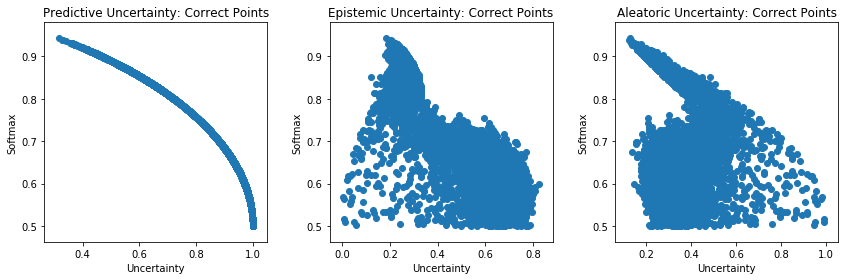

In [12]:
max_softmax_uncertainty(avg_pc, predictive, epistemic, aleatoric)

In [13]:
test_point = np.array([[1, -4]])
predictions = test_model.predict(test_point)
avg_predictions = np.mean(predictions, axis=1)
predictive_uncertainty = - np.sum(avg_predictions * ma.log2(avg_predictions).filled(0), axis=-1)
aleatoric_uncertainty = - 1/K_test * np.sum(predictions * ma.log2(predictions).filled(0), axis=(1,2))
epistemic_uncertainty = predictive_uncertainty - aleatoric_uncertainty
print("Predictions: {}".format(avg_predictions))
print("Max Softmax: {}".format(np.max(avg_predictions, axis=1)))
print("Predictive Uncertainty: {}".format(predictive_uncertainty))
print("Epistemic Uncertainty: {}".format(epistemic_uncertainty))
print("Aleatoric Uncertainty: {}".format(aleatoric_uncertainty))
print(predictions[:, :10, :])

Predictions: [[0.65676063 0.34323943]]
Max Softmax: [0.65676063]
Predictive Uncertainty: [0.92788494]
Epistemic Uncertainty: [0.54395103]
Aleatoric Uncertainty: [0.38393387]
[[[9.8725700e-01 1.2743078e-02]
  [5.1129460e-01 4.8870540e-01]
  [9.9964786e-01 3.5216991e-04]
  [4.9956661e-01 5.0043333e-01]
  [9.9998832e-01 1.1692959e-05]
  [9.8829031e-01 1.1709673e-02]
  [9.9837190e-01 1.6281442e-03]
  [5.1102167e-01 4.8897833e-01]
  [9.9995172e-01 4.8237511e-05]
  [5.1922601e-01 4.8077399e-01]]]


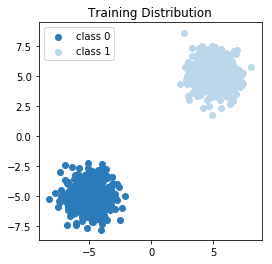

In [14]:
import seaborn as sns
colors = sns.color_palette('Blues_r')
f, ax = plt.subplots(1, 1, figsize=(4, 4))
x = xval
y = yval
xpos = x[np.where(y == 0)]
xneg = x[np.where(y == 1)]
ax.scatter(xpos[:,0], xpos[:,1], color=colors[1], label="class 0")
ax.scatter(xneg[:,0], xneg[:,1], color=colors[4], label="class 1")
ax.set_title("Training Distribution")
ax.legend()

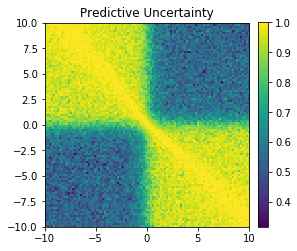

In [15]:
f, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(np.reshape(predictive, (len(testvals), len(testvals))), origin='lower', extent=[-10, 10, -10, 10])
ax.set_title('Predictive Uncertainty')
f.colorbar(im,fraction=0.046, pad=0.04)